In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from scipy import stats
from sklearn.feature_selection import RFE

import warnings

## 4.1 Model Selection

In [2]:
# fit a logistic regression model, calculate AUROC, KS, and absolute difference between training and validating set
# for AUROC and KS. Plot ROC curve using validating set.
# features is an array of feature names, data type is array of strings
# returns a pandas dataframe containing AUROC and KS as well as
# the difference between training and validateing set for both AUROC and KS
def FitLogReg(features):

    X = pd.read_csv('train80.csv').drop(['SK_ID_CURR','TARGET'],axis=1)[features]
    y = pd.read_csv('train80.csv')[['TARGET']]
    
    # further split the 80% training set into 90% training set and 10% validation set
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)
   
    # Scale each feature to 0-1
    scaler1 = MinMaxScaler(feature_range = (0, 1))
    scaler2 = MinMaxScaler(feature_range = (0, 1))
    scaler1.fit(X_train)
    scaler2.fit(X_validate)
    X_train = scaler1.transform(X_train)
    X_validate = scaler2.transform(X_validate)
    
    # fit logistic regression model
    # the parameters are chosen such that it produces the highest AUROC
    log_reg = LogisticRegression(C=0.5, class_weight = 'balanced', random_state=0).fit(X_train, y_train)
    log_reg_prob_train = log_reg.predict_proba(X_train)[:, 1]
    print('Current model with the following {0} features: '.format(features.shape[0]))
    display(features)
    
    # Compute false positive rate, true positive rate, and AUROC for training set
    fpr_logReg_train, tpr_logReg_train, _ = roc_curve(y_train, log_reg_prob_train)
    auroc_logReg_train = roc_auc_score(y_train,log_reg_prob_train)
    
    # compute ks for training set
    y_train['PROB']=log_reg_prob_train
    prob0_df = y_train[y_train['TARGET']==0][['PROB']]
    prob1_df = y_train[y_train['TARGET']==1][['PROB']]
    y_train = y_train.drop(['PROB'],axis=1)
    ks_logReg_train, pvalue_logReg_train = stats.ks_2samp(prob0_df['PROB'],prob1_df['PROB'])
    
    # Compute false positive rate, true positive rate, and AUROC for validating set
    log_reg_prob_validate = log_reg.predict_proba(X_validate)[:, 1]
    fpr_logReg_validate, tpr_logReg_validate, _ = roc_curve(y_validate, log_reg_prob_validate)
    auroc_logReg_validate = roc_auc_score(y_validate,log_reg_prob_validate)
    
    # compute ks for validating set
    y_validate['PROB']=log_reg_prob_validate
    prob0_df = y_validate[y_validate['TARGET']==0][['PROB']]
    prob1_df = y_validate[y_validate['TARGET']==1][['PROB']]
    y_validate = y_validate.drop(['PROB'],axis=1)
    ks_logReg_validate, pvalue_logReg_validate = stats.ks_2samp(prob0_df['PROB'],prob1_df['PROB'])
    
    # create a dataframe containing auroc, ks, and absolute difference between training and validating set
    auroc_ks_df = pd.DataFrame(columns=['Models','AUROC_train','AUROC_validate','KS_train','KS_validate','ABS AUROC diff','ABS KS diff'])
    auroc_ks_df['Models'] = np.array(['Logistic Regression'])
    auroc_ks_df['AUROC_train'] = np.array([auroc_logReg_train])
    auroc_ks_df['AUROC_validate'] = np.array([auroc_logReg_validate])
    auroc_ks_df['KS_train'] = np.array([ks_logReg_train])
    auroc_ks_df['KS_validate'] = np.array([ks_logReg_validate])
    auroc_ks_df['ABS AUROC diff'] = abs(auroc_ks_df['AUROC_train'] - auroc_ks_df['AUROC_validate'])
    auroc_ks_df['ABS KS diff'] = abs(auroc_ks_df['KS_train'] - auroc_ks_df['KS_validate'])
    
    # plot Receiving Operating Curve (ROC)
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr_logReg_validate, tpr_logReg_validate, color='orange',
             lw=2, label='Logistic Regression ROC curve (area = %0.4f)' % auroc_logReg_validate)
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return auroc_ks_df

In [3]:
# calculate feature importance using recursive feature elimination (RFE)
# features is an array of feature names, data type is array of strings
# n_feat is the number of features that need to be selected using RFE, data type is int
# returns an array of features names that are important based on importance scores, data type is array of strings
def Imp_feat(features,n_feat):
    X = pd.read_csv('train80.csv').drop(['SK_ID_CURR','TARGET'],axis=1)[features]
    y = pd.read_csv('train80.csv')[['TARGET']]

    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)
   
    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    log_reg = LogisticRegression(C=0.5, class_weight = 'balanced', random_state=0).fit(X_train, y_train)
    
    selector = RFE(log_reg, n_features_to_select=n_feat, step=1).fit(X_train,y_train)
    imp_features = pd.DataFrame(columns = ['Features','Features_Mask','Ranking']) 
    imp_features['Features'] = features
    imp_features['Features_Mask'] = selector.support_
    imp_features['Ranking'] = selector.ranking_
    imp_features = imp_features.sort_values(by=['Ranking'])
    
    return imp_features

Current model with the following 11 features: 


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
       'DAYS_CREDIT', 'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

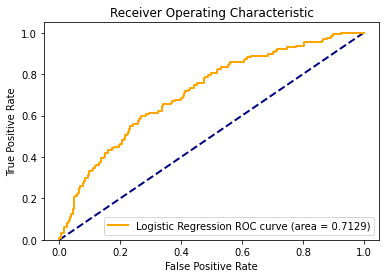

Models  AUROC_train  AUROC_validate  KS_train  KS_validate  \
0  Logistic Regression     0.729326        0.712916  0.352838     0.328931   

   ABS AUROC diff  ABS KS diff  
0         0.01641     0.023907

In [4]:
# fit logistic regression model with 11 features
warnings.filterwarnings("ignore")
features_df = pd.read_csv('Selected_Features.csv')['Features']
features = features_df.to_numpy()
auroc_ks_df = FitLogReg(features)
display(auroc_ks_df)

Logistic regression model satisfies all 4 conditions $AUROC\geq 0.7$, $KS\geq 0.3$, $|AUROC_{train}-AUROC_{validate}|<0.05$, and$|KS_{train}-KS_{validate}|<0.05$. Now we consider dropping one feature and test the nested model.

In [5]:
# use RFE to drop one feature
imp_10features = np.array(Imp_feat(features,10).iloc[:10,0])
print('10 important features')
display(imp_10features)

10 important features


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

## 4.2 Variable selection in nested models
## 4.2.1 Recursive Feature Elimination ( RFE )

Current model with the following 10 features: 


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

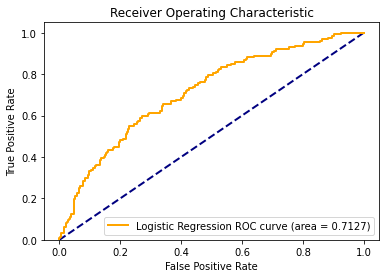

Models  AUROC_train  AUROC_validate  KS_train  KS_validate  \
0  Logistic Regression     0.729346        0.712701  0.353209     0.326651   

   ABS AUROC diff  ABS KS diff  
0        0.016645     0.026557

In [6]:
# fit logistic regression model with 10 features
features = imp_10features
auroc_ks_df = FitLogReg(features)
display(auroc_ks_df)

AUROC decreases by 0.0002 which is not significant, and the model satisfies all 4 conditions $AUROC\geq 0.7$, $KS\geq 0.3$, $|AUROC_{train}-AUROC_{validate}|<0.05$, and$|KS_{train}-KS_{validate}|<0.05$.so we can keep dropping one feature.

In [7]:
# use RFE to drop one feature
imp_9features = np.array(Imp_feat(features,9).iloc[:9,0])
print('9 important features')
display(imp_9features)

9 important features


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

Current model with the following 9 features: 


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

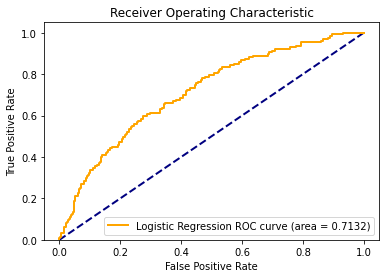

Models  AUROC_train  AUROC_validate  KS_train  KS_validate  \
0  Logistic Regression     0.729193        0.713153  0.353006     0.324371   

   ABS AUROC diff  ABS KS diff  
0         0.01604     0.028635

In [8]:
# fit logistic regression model with 9 features 
features = imp_9features
auroc_ks_df = FitLogReg(features)
display(auroc_ks_df)

AUROC increases by 0.0005, and it satisfies all 4 conditions $AUROC\geq 0.7$, $KS\geq 0.3$, $|AUROC_{train}-AUROC_{validate}|<0.05$, and$|KS_{train}-KS_{validate}|<0.05$. so we keep eliminating one feature.

In [9]:
# use RFE to drop one feature
imp_8features = np.array(Imp_feat(features,8).iloc[:8,0])
print('8 important features')
display(imp_8features)

8 important features


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype=object)

Current model with the following 8 features: 


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       'DAYS_EMPLOYED_IMPUTED', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype=object)

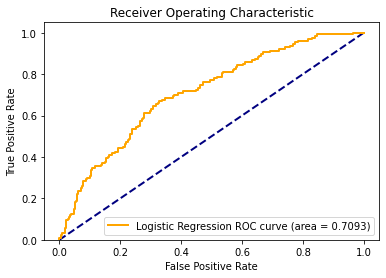

Models  AUROC_train  AUROC_validate  KS_train  KS_validate  \
0  Logistic Regression     0.725678        0.709329  0.346572     0.341886   

   ABS AUROC diff  ABS KS diff  
0        0.016349     0.004686

In [10]:
# fit logistic regression model with 8 features
features = imp_8features
auroc_ks_df = FitLogReg(features)
display(auroc_ks_df)

Despite it satisfies all 4 conditions $AUROC\geq 0.7$, $KS\geq 0.3$, $|AUROC_{train}-AUROC_{validate}|<0.05$, and$|KS_{train}-KS_{validate}|<0.05$, the AUROC for nested model with 8 features decreases by 0.0039 compared with 9 features. So, our final model has 9 features.

## Our final model is logistic regression model with 9 features: AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL, DAYS_EMPLOYED_IMPUTED, DAYS_ID_PUBLISH, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, and NAME_EDUCATION_TYPE_Higher education

In [11]:
# export the 9 final feature names to a csv file
final_features_df = pd.DataFrame(columns=['Features'])
final_features_df['Features'] = imp_9features
final_features_df.to_csv('Final_Features.csv')